# A Recurrent Network Mechanism of Time Integration in Perceptual Decisions
Wong,  Wang
Journal of Neuroscience, January 2006, 26(4):1212-1328

## Material and Methods
### The two-variable network model

### Calling Library Fuctions

In [1]:
# LIBRARY

import numpy as np # vector manipulation
import math  # math functions
import sys

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")


### The Reduced Network Model

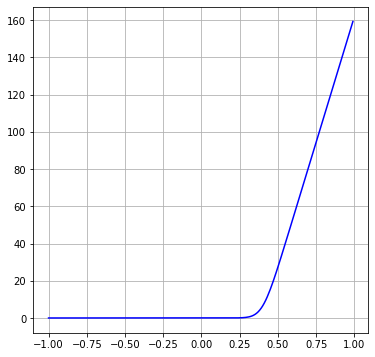

In [2]:
def H(x):
    a=270 # Hz/nA
    b=108 # Hz
    d=.154 # seconds
    f=(a*x-b)/(1-np.exp(-d*(a*x-b)))
    return f
x=np.arange(-1,1,0.01)
fig = plt.figure(figsize=(6,6))
plt.plot(x,H(x),'-',color='blue')
plt.grid()
plt.show()

### Neural Circuit
$$ x_{1}=J_{11}S_1-J_{12}S_2+I_{0}+I_{1}+I_{noise,1}$$
$$ x_{2}=J_{22}S_2-J_{21}S_1+I_{0}+I_{2}+I_{noise,1}$$

where the synaptic couplings are $J_{11}=0.2609$, $J_{22}=0.2609$, $J_{12}=0.0497$ and $J_{21}=0.0497$.
$I_{0}=0.3255 nA$ represents external input 


In [3]:
def total_synaptic_current(S_1,S_2,I_1,I_2,I_noise_1,I_noise_2):
    # Synaptic coupling
    J_11=0.2609 # nA
    J_22=0.2609 # nA
    J_12=0.0497 # nA
    J_21=0.0497 # nA
    I_0=0.3255  # nA
    x_1=J_11*S_1-J_12*S_2+I_0+I_1+I_noise_1
    x_2=J_22*S_2-J_21*S_1+I_0+I_2+I_noise_2
    return x_1, x_2


### Background activity
$$ \tau_{AMPA}\frac{d I_{noise,i}(t)}{dt} =-I_{noise,i}(t)+\eta_i(t)\sqrt{\tau_{AMPA}}\sigma_{noise}$$

In [4]:
def Background_Activity(I_noise):
    h=0.1/1000
    sigma_noise=0.02 # nA
    tau_AMPA=2 #ms
    eta_noise=0.1*np.random.uniform(0,1,1)
    k=(-(I_noise)+eta_noise*np.sqrt(tau_AMPA)*sigma_noise)
    I_noise_new=I_noise+h/tau_AMPA*(-(I_noise+h/2*k)+eta_noise
                                *np.sqrt(tau_AMPA)*sigma_noise)
    return I_noise_new

### Network Dynamics
$$ \frac{d S_{i}}{dt} =-\frac{S_{i}}{\tau_S}+(1-S_{i})\gamma H_{i}$$

In [5]:
def Network_Dynamics(S,x):
    h=0.1/1000 #ms
    gamma=0.641
    tau_S=.100 #s
    k=(-S/tau_S+(1-S)*gamma*H(x)/1)
    S_new=S+h*(-(S+h/2*k)/tau_S+(1-S+h/2*k)*gamma*H(x))
    return S_new




### Input Current Target

$$ I_i=J_{A,ext}\mu_0\left(1+ \frac{c'}{100} \right) $$


In [6]:
def I_input_1(c_dash):
    J_A_ext=5.2/10000 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1+(c_dash)/100)
    return I_motion

$$ I_2=J_{A,ext}\mu_0\left(1- \frac{c'}{100} \right) $$

In [7]:
def I_input_2(c_dash):
    J_A_ext=0.00052 # nA/Hz
    mu_0=30 # Hz
    I_motion=J_A_ext*mu_0*(1-(c_dash)/100)
    return I_motion

In [8]:
h=0.1
time=np.arange(-100,1500,h)
J_A_ext=0.00052 # nA/Hz
mu_0=30 # Hz





In [9]:
c_dash=25.0
N=100
ANSWER=np.zeros(N)
RT=np.zeros(N)
count=0
ALL_S_1=0.2*np.ones((N,len(time)))
ALL_S_2=0.2*np.ones((N,len(time)))
ALL_F_1=0.2*np.ones((N,len(time)))
ALL_F_2=0.2*np.ones((N,len(time)))
for n in range(0,N):
    I_noise_1=0.001*np.random.normal(0,1,len(time))
    I_noise_2=0.001*np.random.normal(0,1,len(time))

    x_1=0*J_A_ext*mu_0*np.random.uniform(0,1,len(time))
    x_2=0*J_A_ext*mu_0*np.random.uniform(0,1,len(time))

    S_1=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time))#0.1*np.random.uniform(0,1,len(time))# np.random.normal(0,1,len(time))*0.0004
    S_2=0.2*np.ones(len(time))+0.01*np.random.normal(0,1,len(time)) #0.1*np.random.uniform(0,1,len(time)) #np.random.normal(0,1,len(time))*0.0004

    I_1=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
    I_2=0.0*np.ones(len(time)) # np.zeros((1,len(time)))
    Firing_target_1=0*time # np.zeros((1,len(time)))
    Firing_target_2=0*time # np.zeros((1,len(time)))

    if n%25==0:
        print(n)
    count=0
    for i in range (0,len(time)-1):
        if time[i] >=0 and time[i]<1000:
            c_dash=2.0
        else:
            c_dash=0.0


        Firing_target_1[i]=H(x_1[i])
        Firing_target_2[i]=H(x_2[i])

       # I_noise_1[i+1]=0.0*Background_Activity(I_noise_1[i])
        # I_noise_2[i+1]=0.0*Background_Activity(I_noise_2[i])

        I_1[i+1]=I_input_1(c_dash)
        I_2[i+1]=I_input_1(-c_dash)

        x_1[i+1],x_2[i+1]=total_synaptic_current(S_1[i],S_2[i],I_1[i],I_2[i],I_noise_1[i],I_noise_2[i])
        S_1[i+1]=Network_Dynamics(S_1[i],x_1[i+1])
        S_2[i+1]=Network_Dynamics(S_2[i],x_2[i+1])
        if count <0.5:
            if Firing_target_1[i] >=15: 
                ANSWER[n]=0 
                RT[n]=time[i]
                count=1
            elif Firing_target_2[i] >=15:
                ANSWER[n]=1
                RT[n]=time[i]
                count=1
    ALL_F_1[n,:]=Firing_target_1
    ALL_F_2[n,:]=Firing_target_2
    ALL_S_1[n,:]=Firing_target_1
    ALL_S_2[n,:]=Firing_target_2

0
25
50
75


### Plotting
#### Input

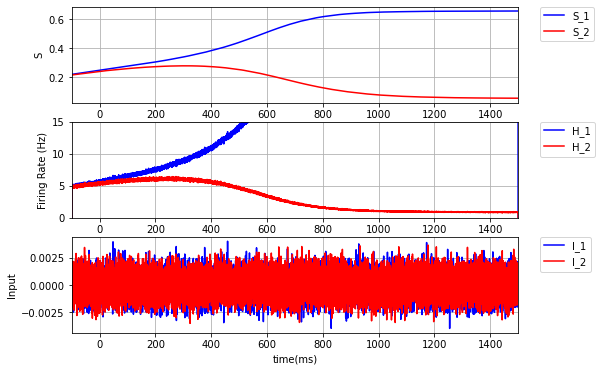

In [10]:
fig = plt.figure(figsize=(8,6))
plt.subplot(311)
plt.plot(time,S_1,'-',color='blue',label="S_1")
plt.plot(time,S_2,'-',color='red',label="S_2")
plt.grid()
plt.xlim((-100,1500))
plt.xlabel('time(ms)')
plt.ylabel('S')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(312)
plt.plot(time,Firing_target_1,'-',color='blue',label="H_1")
plt.plot(time,Firing_target_2,'-',color='red',label="H_2")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Firing Rate (Hz)')
plt.xlim((-100,1500))
plt.ylim((0,15))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(313)
plt.plot(time,I_noise_1,'-',color='blue',label="I_1")
plt.plot(time,I_noise_2,'-',color='red',label="I_2")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('Input')
plt.xlim((-100,1500))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.
#plt.ylim((30,50))
plt.show()


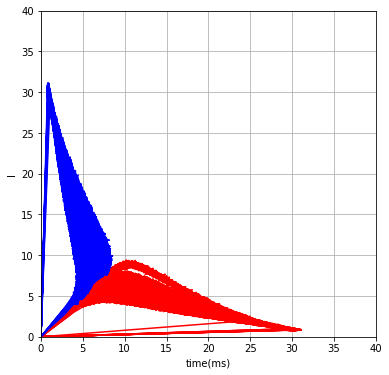

In [11]:
fig = plt.figure(figsize=(6,6))
for n in range(0,N):
    if ANSWER[n]==0:
        plt.plot(ALL_S_2[n,:],ALL_S_1[n,:],'-',color='blue')
    else:
        plt.plot(ALL_S_2[n,:],ALL_S_1[n,:],'-',color='red')

        #plt.plot(S_2,S_1,'-',color='blue',label="S_1")
plt.grid()
plt.xlabel('time(ms)')
plt.ylabel('I')
plt.xlim((0,40))
plt.ylim((0,40))
plt.show()

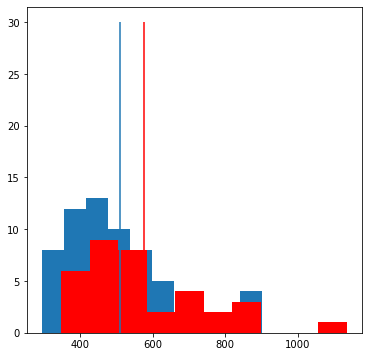

In [12]:
fig = plt.figure(figsize=(6,6))
plt.hist(RT[ANSWER==0])
plt.hist(RT[ANSWER==1],color="red")
plt.vlines(np.average(RT[ANSWER==1]),0,30,color="red")

plt.vlines(np.average(RT[ANSWER==0]),0,30)
plt.show()

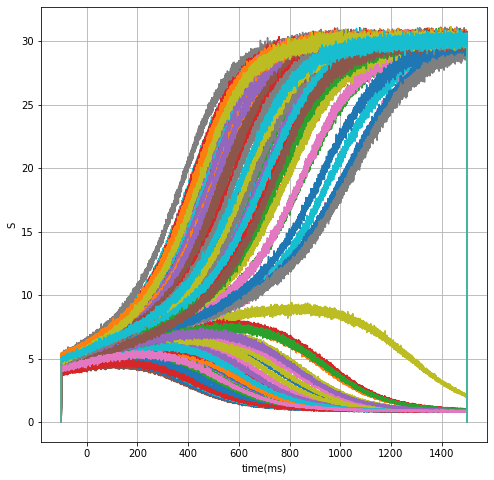

In [13]:
fig = plt.figure(figsize=(8,8))
for n in range(0,N):
    plt.plot(time,ALL_S_1[n,:],'-')
plt.grid()
#plt.xlim((-100,1500))
plt.xlabel('time(ms)')
plt.ylabel('S')
plt.show()

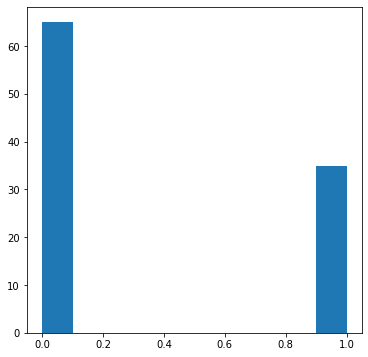

In [14]:
fig = plt.figure(figsize=(6,6))
plt.hist(ANSWER)
plt.show()